# 4.1 Random Forest Regression Dual-Metal LOGOCV Analysis

## Notebook Setup: Imports and Configuration


In [1]:
# ─────────────────────────────
# Standard Library Imports
# ─────────────────────────────
import os
import sys
import time
import copy
import re
import itertools as it
from pprint import pprint

# ─────────────────────────────
# Adjust sys.path for Local Modules
# ─────────────────────────────
sys.path.append(os.path.abspath(os.path.join('..', '..', 'src')))

# ─────────────────────────────
# Third-Party Imports
# ─────────────────────────────
import numpy as np
import pandas as pd
from scipy.stats import norm
from tqdm.notebook import tqdm
from tqdm import trange

# Sklearn
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.pipeline import Pipeline

# Plotly
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, plot
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
import plotly.express as px
import plotly.io as pio

# Matplotlib
import matplotlib.pyplot as plt

# ─────────────────────────────
# Project-Specific Imports
# ─────────────────────────────
from settings import *
from utils import *
from vis import *
from ml import *

# ─────────────────────────────
# Notebook Display & Pandas Options
# ─────────────────────────────
import warnings
from scipy.linalg import LinAlgWarning
from IPython.core.interactiveshell import InteractiveShell

# Pandas display settings
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("mode.chained_assignment", None)
pd.options.display.max_colwidth = 200

# Jupyter interactive output
InteractiveShell.ast_node_interactivity = "all"

# Enable Plotly notebook mode
init_notebook_mode(connected=True)

# ─────────────────────────────
# Suppress Warnings
# ─────────────────────────────
warnings.filterwarnings(action="ignore", category=LinAlgWarning, module="sklearn")
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)


## Load Random Forest Regression Results (Dual-Metal LOGOCV)

In [2]:
# Load the data
data_rfr_dacs_mlogocv = "../../../data/out/df_rfr_dacs_results_metal_logocv.csv"
dacs_mlogocv = pd.read_csv(data_rfr_dacs_mlogocv)


## Filter Random Forest Predictions by Dual-Metal Pair


This section filters the full LOGO-CV RFR dataset into separate DataFrames for each metal listed in `M1`. 
For each metal:
- The predicted adsorption energies across all CV splits (`pred_00000` to `pred_00013`) are averaged.
- The filtered dataset is saved as a separate CSV file.
- All DataFrames are stored in a dictionary (`metal_dfs`) for later access.


In [3]:
# List of metals you want to filter
metals = ['Fe', 'Co', 'Ni', 'Cu', 'Zn', 'Ru', 'Rh', 'Pd', 'Ag', 'Cd', 'Os', 'Ir', 'Pt', 'Au']

# Dictionary to hold DataFrames for each metal
metal_dfs = {}

# Loop over each metal in the list
for metal in metals:
    # Filter rows where M1 column equals the metal
    metal_df = dacs_mlogocv[dacs_mlogocv['M1'] == metal]
    
    # Compute the average of the predicted values (columns pred_00000 to pred_00013)
    pred_columns = [f'pred_{i:05d}' for i in range(14)]  # Generate column names pred_00000 to pred_00013
    metal_df['predicted_average'] = metal_df[pred_columns].mean(axis=1)
    
    # Create the file name dynamically based on the metal
    file_name = f"../../../data/out/{metal}_dacs_mlogocv_rfr.csv"
    
    # Save the filtered data to a CSV file
    metal_df.to_csv(file_name, index=False)
    
    # Store the DataFrame in the dictionary with the metal name as the key
    metal_dfs[metal] = metal_df

# Now, metal_dfs dictionary contains all the updated DataFrames, accessible by metal names.
# For example, to access the DataFrame for 'Fe':
fe_df = metal_dfs['Fe']
co_df = metal_dfs['Co']
ni_df = metal_dfs['Ni']
cu_df = metal_dfs['Cu']
zn_df = metal_dfs['Zn']
ru_df = metal_dfs['Ru']
rh_df = metal_dfs['Rh']
pd_df = metal_dfs['Pd']
ag_df = metal_dfs['Ag']
cd_df = metal_dfs['Cd']
os_df = metal_dfs['Os']
ir_df = metal_dfs['Ir']
pt_df = metal_dfs['Pt']
au_df = metal_dfs['Au']



## RFR Dual-Metal LOGOCV Error Metrics

In [4]:

# List of metals
metals = ['Fe', 'Ir', 'Au', 'Pd', 'Cu', 'Ag', 'Zn', 'Pt', 'Ni', 'Os', 'Rh', 'Co', 'Ru', 'Cd']

# Provided values for each metric (as strings)
rmse_trains = [0.26487986399394875, 0.26647364779663385, 0.2630454096981317, 0.2640541803491138, 0.2678718757710656, 0.2638099669420883, 0.26090754989622633, 0.2691887672882594, 0.2598325677765208, 0.2597904901169187, 0.27174710624093723, 0.25832178915678206, 0.27226565457019675, 0.2553378310656494]
rmse_tests = [0.5563464108878543, 0.6483109374889681, 0.6012663501867291, 0.38715586521325546, 0.41580832559422487, 0.5718981196912717, 0.357185767392372, 0.5459795983911094, 0.6906016513853266, 0.46466528831425846, 0.4283998252201117, 0.789453537343277, 0.6218651344144391, 0.7368215112244012]
rmse_fulls = [0.29342807132783716, 0.3103351240839664, 0.3006097164785652, 0.2751695096531806, 0.28016104816195186, 0.2940061999623375, 0.26955714494493394, 0.29932557083462574, 0.3124825420457866, 0.2803357369344649, 0.28599055253898714, 0.3241720282390356, 0.3104901110645438, 0.31235478130158023]
mae_trains = [0.20861607434891927, 0.2073459262223797, 0.20437958530316502, 0.2061680581170742, 0.21058310542531486, 0.20557041960561276, 0.20245750366596166, 0.21064594008031917, 0.2029689866839879, 0.20285686132897776, 0.21245419334559015, 0.20008407843977516, 0.2125497430996839, 0.20159254908396199]
mae_tests = [0.49658332090235313, 0.5003466868822737, 0.5173406956204788, 0.3282475240080142, 0.28442712415231286, 0.47453716979631066, 0.28703686616749197, 0.4928069809407488, 0.6106605343234895, 0.3729970702096379, 0.33452790717771685, 0.7051208948527934, 0.5522055653470951, 0.6114181754177191]
mae_fulls = [0.2277914634301643, 0.22856794393372717, 0.2270473292747462, 0.2152954948192006, 0.21550028891531356, 0.22316637522556496, 0.20897880965322915, 0.23207172005219756, 0.23297432254997927, 0.2155776246097748, 0.22129598102969275, 0.2348938590102986, 0.2367541883766606, 0.2293611078776044]
rsquared_trains = [0.9729475932651782, 0.972259751770131, 0.9729637162289049, 0.9733581275779531, 0.9713421195342002, 0.9737956750841772, 0.97320857419966, 0.9705090271026107, 0.9738882289028292, 0.9742072781410906, 0.9703945250907144, 0.972723684696554, 0.9710154504527282, 0.9752755516112341]
rsquared_tests = [0.8525130627265745, 0.8094176428954335, 0.7495055746548459, 0.9165003255467168, 0.9442400159152078, 0.6381904072555958, 0.9544230144111159, 0.8943571573917912, 0.7058301974613657, 0.8844173675589421, 0.9400849824506942, 0.816535042847807, 0.819639101920878, 0.6039207707541829]
rsquared_fulls = [0.9663823702861503, 0.962396728031726, 0.9647166511085803, 0.9704359184879656, 0.9693536132285517, 0.9662497690625993, 0.9716295994926611, 0.965017454314993, 0.9618745227316824, 0.9693153834405028, 0.9680649835083912, 0.9589687405620041, 0.9623591591428794, 0.9619056921119478]

# Create a DataFrame from the data
data = {
    'Metal': metals,
    'rmse_trains': rmse_trains,
    'rmse_tests': rmse_tests,
    'rmse_fulls': rmse_fulls,
    'mae_trains': mae_trains,
    'mae_tests': mae_tests,
    'mae_fulls': mae_fulls,
    'rsquared_trains': rsquared_trains,
    'rsquared_tests': rsquared_tests,
    'rsquared_fulls': rsquared_fulls,
}

data_error = pd.DataFrame(data)

# Save the DataFrame as a CSV file
# output_file = '../../../data/out/mlogocv_errors_rfr.csv'
# data_error.to_csv(output_file, index=False)
# data_error.head()


## Parity plots for Dual-Metal LOGOCV

This visualization compares the predicted adsorption energies from a Random Forest Regressor (RFR) model to the DFT-calculated values (`E$_{ads}^{DFT}$`) for 14 different metal single-atom catalysts (SACs) supported on Fe.

Each subplot includes:
- A scatter plot of actual (`y`) vs. predicted (`E$_{ads}^{RFR}$`) adsorption energies.
- A 45° reference line representing perfect prediction.
- An inset histogram showing the distribution of prediction errors (DFT - RFR).
- Annotated performance metrics:  
  - $R^2$: Coefficient of determination  
  - RMSE: Root Mean Squared Error  
  - MAE: Mean Absolute Error

Metal-specific colors are used for easy visual distinction. All plots are saved in `.svg`, `.png`, and `.pdf` formats to the specified output directory.

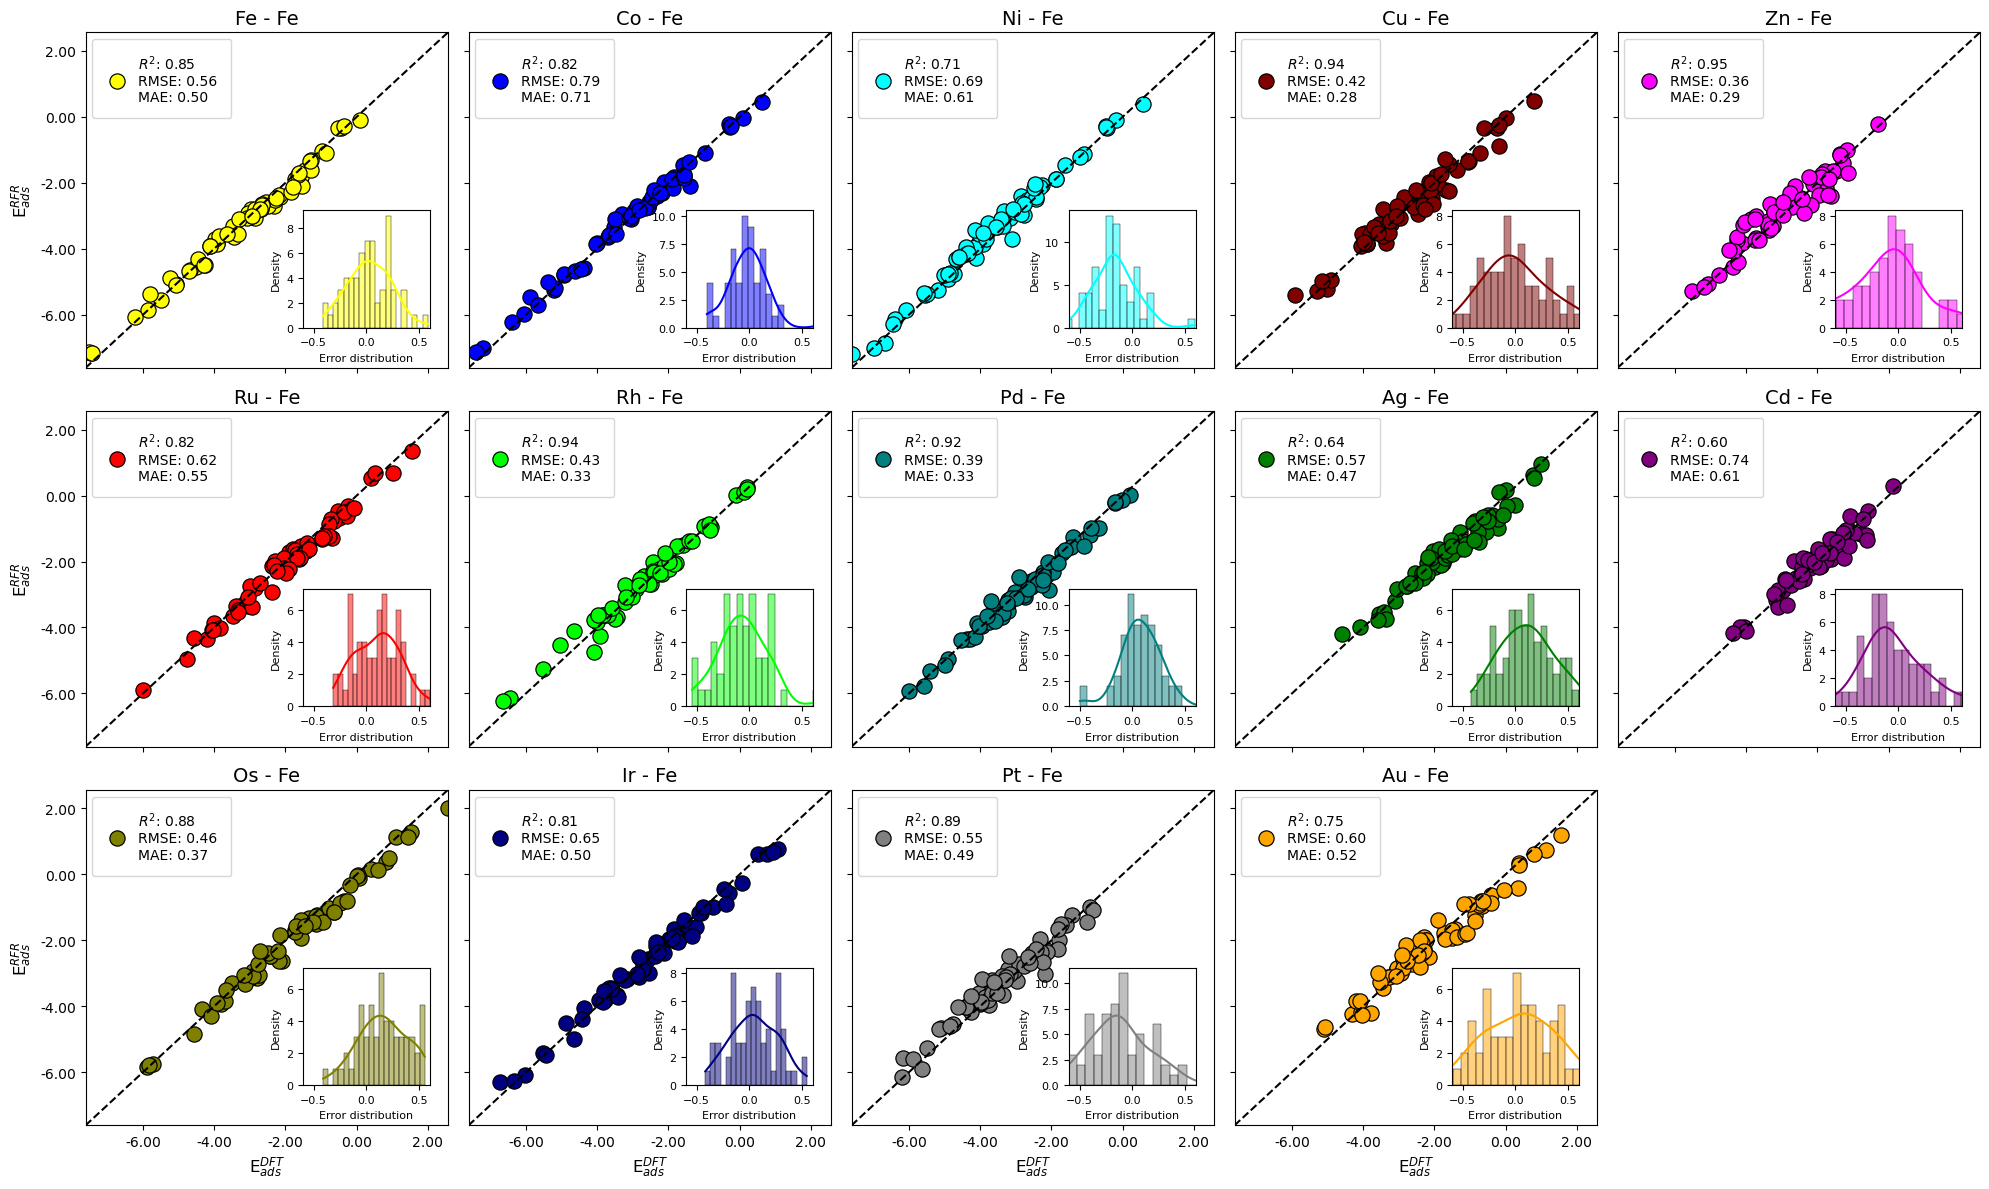

In [5]:
# Define the color mapping for metals
metal_colors = {
    "Ru": (1.0, 0.0, 0.0),  # Red
    "Rh": (0.0, 1.0, 0.0),  # Green
    "Co": (0.0, 0.0, 1.0),  # Blue
    "Fe": (1.0, 1.0, 0.0),  # Yellow
    "Zn": (1.0, 0.0, 1.0),  # Magenta
    "Ni": (0.0, 1.0, 1.0),  # Cyan
    "Os": (0.5, 0.5, 0.0),  # Olive
    "Cd": (0.5, 0.0, 0.5),  # Purple
    "Pd": (0.0, 0.5, 0.5),  # Teal
    "Cu": (0.5, 0.0, 0.0),  # Maroon
    "Ag": (0.0, 0.5, 0.0),  # Light Green
    "Ir": (0.0, 0.0, 0.5),  # Navy
    "Au": (1.0, 0.647, 0.0),  # Orange
    "Pt": (0.5, 0.5, 0.5),  # Gray
}


datasets = {
    'Fe': fe_df,
    'Co': co_df,
    'Ni': ni_df,
    'Cu': cu_df,
    'Zn': zn_df,
    'Ru': ru_df,
    'Rh': rh_df,
    'Pd': pd_df,
    'Ag': ag_df,
    'Cd': cd_df,
    'Os': os_df,
    'Ir': ir_df,
    'Pt': pt_df,
    'Au': au_df
}

output_folder = "../../../data/figures/rfr_results"

plot_rfr_mlogocv_results(datasets, data_error, metal_colors, output_path=output_folder)
